## Uni-directional and Multi-directional Speed Analysis
- Install
- Imports
- Download Data
- Configuration
- Source and Target ROIs
- Shadow Perspective
- Process Video
- Save .CSV

In [1]:
!nvidia-smi

Tue Mar 25 22:11:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
| 30%   35C    P5             42W /  350W |   20976MiB /  24576MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install -q git+https://github.com/THU-MIG/yolov10.git

# YOLOv12
# !pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

# RT-DETR
# !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q git+https://github.com/roboflow/supervision.git
# !pip install -q accelerate
# !pip install -q roboflow
# !pip install -q torchmetrics
# !pip install -q "albumentations>=1.4.5"

# YOLO-NAS
# !pip install -q roboflow==1.1.49
# !pip install -q supervision==0.25.0

# !pip install -q git+https://github.com/Deci-AI/super-gradients.git@stable
# !sed -i -e "s/sghub.deci.ai/sg-hub-nv.s3.amazonaws.com/g" /usr/local/lib/python3.10/dist-packages/super_gradients/training/pretrained_models.py
# !sed -i -e "s/sghub.deci.ai/sg-hub-nv.s3.

## Install

In [3]:
!pip install -q supervision ultralytics roboflow

## Imports

In [4]:
import cv2

import numpy as np
import supervision as sv
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

In [ ]:
# !ffprobe -version

#### Checking Dimensions of the video.

In [5]:
!ffprobe -v error -select_streams v:0 -show_entries stream=width,height -of csv=p=0 gameflow/2.mp4

1280,720


#### Checking Frame_Rate of the video

In [6]:
!ffprobe -v error -select_streams v:0 -show_entries stream=r_frame_rate -of default=noprint_wrappers=1:nokey=1 gameflow/2.mp4

60000/1001


#### Checking # of Frames in a video

In [7]:
import cv2

video_path = 'videos/2.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open the video file.")
    exit()

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total Frames in the video:", total_frames)
cap.release()

Total Frames in the video: 1007


In [1]:
# from ipywidgets import Video
# Video.from_file('gameflow/2.mp4', width=320, height=320)

In [9]:
SOURCE_VIDEO_PATH = "gameflow/2.mp4"
TARGET_VIDEO_PATH = "gameflow/gf.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "b3c.pt"          # "yolov10s.pt" "yolov8x.pt" rtdetr.pt, yolo11s.pt,  yolo8s-world.pt, yolov8n.pt
MODEL_RESOLUTION = 1280  #848  #720

### Source and Target ROIs

In [10]:

# Source points 
FOOTBALL_SOURCE = np.array([[0, 0], [1280, 0], [1280, 900], [0, 2000]])

# Target dimensions for the transformed football pitch
FOOTBALL_TARGET_WIDTH = 25
FOOTBALL_TARGET_HEIGHT = 250

# Target points
FOOTBALL_TARGET = np.array(
    [
        [0, 0],
        [FOOTBALL_TARGET_WIDTH - 1, 0],
        [FOOTBALL_TARGET_WIDTH - 1, FOOTBALL_TARGET_HEIGHT - 1],
        [0, FOOTBALL_TARGET_HEIGHT - 1],
    ]
)

In [11]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

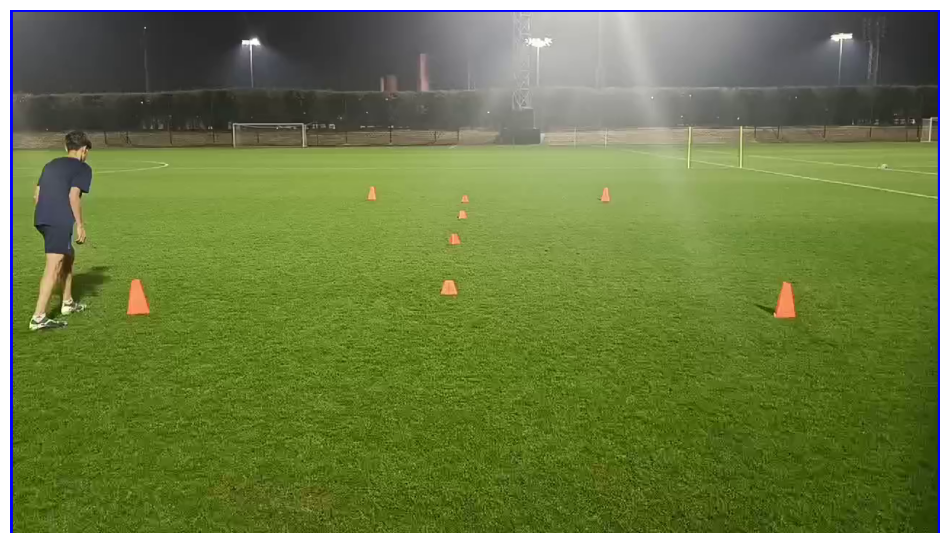

In [12]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=FOOTBALL_SOURCE, color=sv.Color.BLUE, thickness=6)
sv.plot_image(annotated_frame)

### Transform Perspective

In [13]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [14]:
view_transformer = ViewTransformer(source=FOOTBALL_SOURCE, target=FOOTBALL_TARGET)

### Speed Analysis

In [2]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
byte_track = sv.ByteTrack(frame_rate=video_info.fps)

# Annotators configuration
thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
bounding_box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(polygon=FOOTBALL_SOURCE)
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))
speed_data = pd.DataFrame(columns=['Id', 'Class', 'Accuracy', 'Speed (km/h)', 'Position', 'Distance'])

player_speed_m_per_sec = 5  # max is 7
frame_rate = 60  # 30
movement_step = player_speed_m_per_sec / frame_rate

field_width_meters = 68  # Soccer pitch width is (68 -70)
video_width_pixels = 1280  # 1920    #848
pixels_per_meter = video_width_pixels / field_width_meters
movement_step_pixels = movement_step * pixels_per_meter

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[np.isin(detections.class_id, [0, 32, 34, 35])]
        detections = detections[polygon_zone.trigger(detections)]
        detections = detections.with_nms(IOU_THRESHOLD)
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        points = view_transformer.transform_points(points=points).astype(int)

        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        labels = []
        for tracker_id, class_id, confidence in zip(detections.tracker_id, detections.class_id, detections.confidence):
            class_name = {0: 'Player', 32: 'Ball', 34: 'Goalkeeper', 35: 'Referee'}.get(class_id, 'Unknown')
            accuracy = f"{round(confidence * 100, 2):.2f}"

            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"{class_name} Id:{tracker_id} {accuracy}%")
            else:
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                speed = min(speed, 40.7 * 0.9)

                new_data = pd.DataFrame([{
                    'Id': tracker_id,
                    'Class': class_name,
                    'Accuracy': accuracy,
                    'Speed (km/h)': speed,
                    'Position': coordinates[tracker_id][-1],
                    'Distance': distance
                }])

                speed_data = pd.concat([speed_data, new_data], ignore_index=True)
                labels.append(f"{class_name} Id:{tracker_id} {accuracy}% Speed:{int(speed)} km/h")

        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
        sink.write_frame(annotated_frame)

speed_data.to_csv('gameflow/gf.csv', index=False)

In [ ]:
import supervision as sv
print(dir(sv))

In [ ]:
gameflow = pd.read_csv('gameflow/gf.csv')
gameflow.head()